# A6a-Time Series Analysis

Name : Aakash Kathirvel

VID : V01110153

Date : 07/22/2024

In [4]:
pip install yfinance pandas numpy matplotlib statsmodels scikit-learn tensorflow

Note: you may need to restart the kernel to use updated packages.


# Download the Data

In [5]:
import yfinance as yf

# Download data
stock_symbol = 'AAPL'  # Example: Apple Inc.
data = yf.download(stock_symbol, start='2020-01-01', end='2024-01-01')

# Save the data to a CSV file
data.to_csv('stock_data.csv')

# Display the first few rows of the data
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960457  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251144  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826859  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484352  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650360  132079200


# Clean the Data

In [6]:
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('stock_data.csv', index_col='Date', parse_dates=True)

In [7]:
# Check for missing values
print(data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [8]:
# Interpolate missing values
data.interpolate(method='linear', inplace=True)

In [9]:
# Check for outliers using Z-score
from scipy.stats import zscore

z_scores = np.abs(zscore(data.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).any(axis=1)
print(f'Number of outliers: {np.sum(outliers)}')

Number of outliers: 24


In [10]:
# Remove outliers
data = data[~outliers]

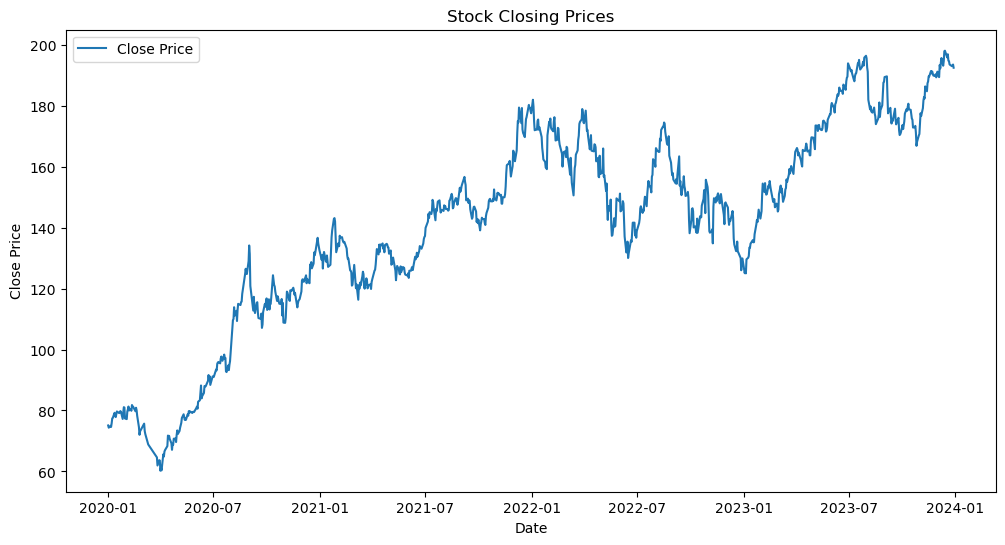

In [11]:
# Plot the cleaned data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price')
plt.title('Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Create Train and Test Data Sets

In [12]:
from sklearn.model_selection import train_test_split

# Define features and target
features = data.drop(columns=['Close'])
target = data['Close']

In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Verify the splits
print(f'Training data size: {len(X_train)}')
print(f'Test data size: {len(X_test)}')

Training data size: 785
Test data size: 197


# Convert Data to Monthly and Decompose Time Series

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample data to monthly frequency
monthly_data = data['Close'].resample('M').mean()

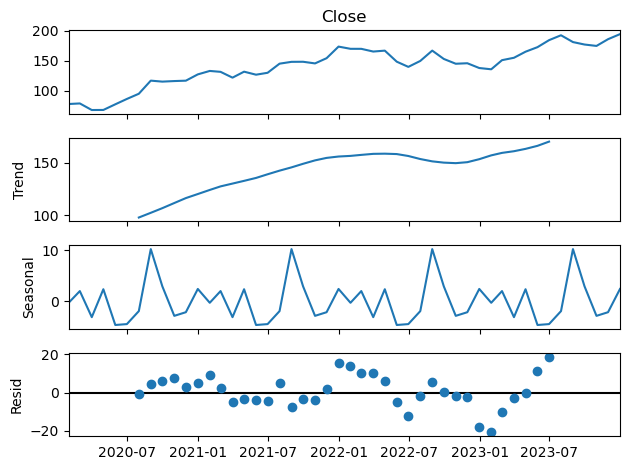

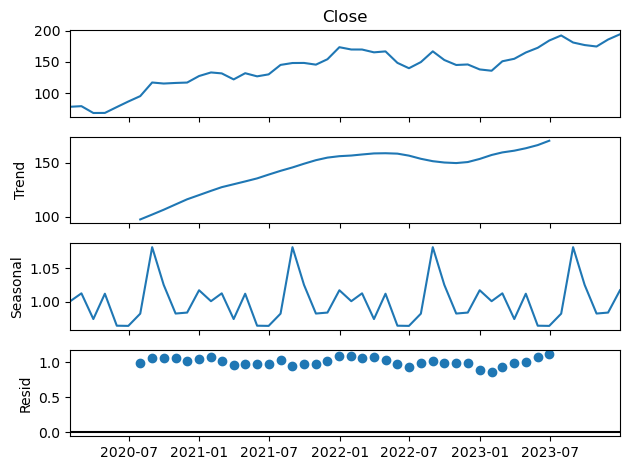

In [15]:
# Decompose the time series
decomposition = seasonal_decompose(monthly_data, model='additive')
decomposition.plot()
plt.show()

decomposition = seasonal_decompose(monthly_data, model='multiplicative')
decomposition.plot()
plt.show()

# Univariate Forecasting

## Holt-Winters Model

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


# Fit the Holt-Winters model
model_hw = ExponentialSmoothing(monthly_data, trend='add', seasonal='add', seasonal_periods=12)
fit_hw = model_hw.fit()

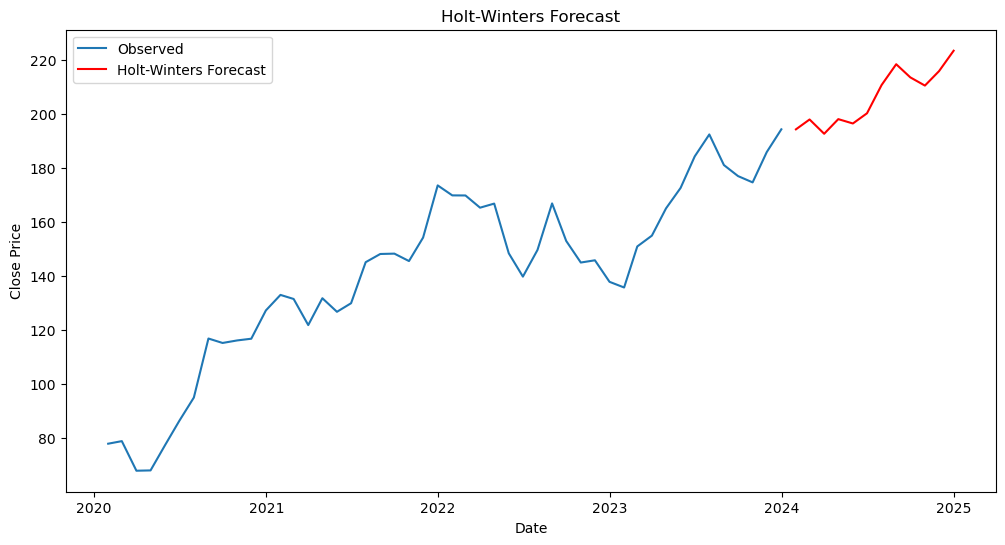

In [21]:
# Forecast for the next year
forecast_hw = fit_hw.forecast(steps=12)
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Observed')
plt.plot(forecast_hw, label='Holt-Winters Forecast', color='red')
plt.title('Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [22]:
# In-sample prediction (if evaluating on training data)
forecast_hw_in_sample = fit_hw.fittedvalues

In [23]:
# Calculate metrics for in-sample predictions
rmse_hw = np.sqrt(mean_squared_error(monthly_data, forecast_hw_in_sample))
mae_hw = mean_absolute_error(monthly_data, forecast_hw_in_sample)
mape_hw = np.mean(np.abs((monthly_data - forecast_hw_in_sample) / monthly_data)) * 100
r2_hw = r2_score(monthly_data, forecast_hw_in_sample)

print(f'Holt-Winters Model - RMSE: {rmse_hw}')
print(f'Holt-Winters Model - MAE: {mae_hw}')
print(f'Holt-Winters Model - MAPE: {mape_hw}')
print(f'Holt-Winters Model - R-squared: {r2_hw}')

Holt-Winters Model - RMSE: 7.269778202574118
Holt-Winters Model - MAE: 5.702371837371747
Holt-Winters Model - MAPE: 4.257993881985675
Holt-Winters Model - R-squared: 0.9509871887191886


## ARIMA Model

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the ARIMA model
model_arima = ARIMA(monthly_data, order=(5, 1, 0))
fit_arima = model_arima.fit()

In [25]:
# Diagnostic check
print(fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   48
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -169.390
Date:                Mon, 22 Jul 2024   AIC                            350.780
Time:                        17:02:23   BIC                            361.881
Sample:                    01-31-2020   HQIC                           354.957
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2449      0.195      1.257      0.209      -0.137       0.627
ar.L2         -0.1419      0.191     -0.744      0.457      -0.516       0.232
ar.L3         -0.0023      0.180     -0.013      0.9

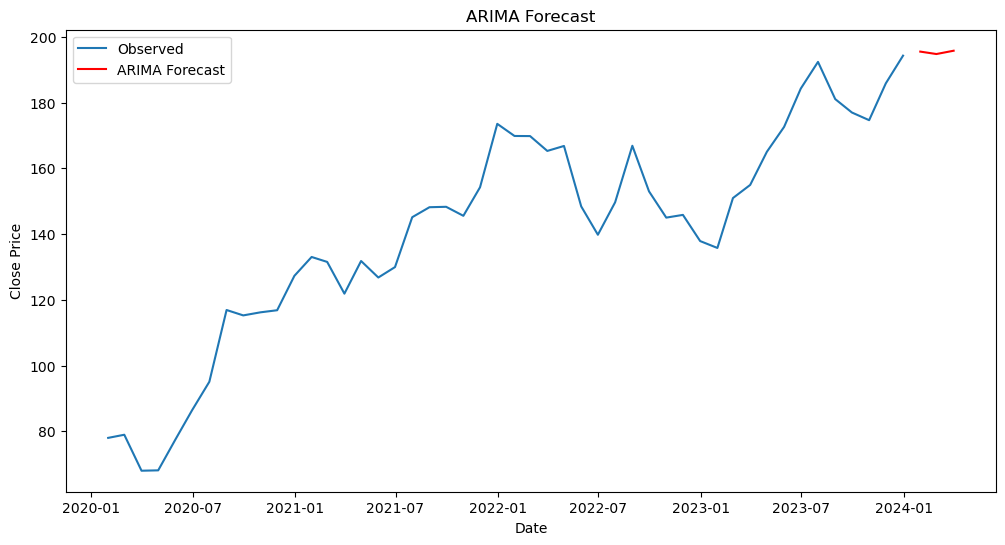

In [27]:
# Forecast for the next three months
forecast_arima = fit_arima.forecast(steps=3)
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Observed')
plt.plot(pd.date_range(start=monthly_data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M'), forecast_arima, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [33]:
# Predict on the training data
forecast_arima_train = fit_arima.predict(start=0, end=len(monthly_data)-1)

In [34]:
# Compute metrics for ARIMA
rmse_arima = np.sqrt(mean_squared_error(monthly_data, forecast_arima_train))
mae_arima = mean_absolute_error(monthly_data, forecast_arima_train)
mape_arima = np.mean(np.abs((monthly_data - forecast_arima_train) / monthly_data)) * 100
r2_arima = r2_score(monthly_data, forecast_arima_train)

print(f'ARIMA Model - RMSE: {rmse_arima}')
print(f'ARIMA Model - MAE: {mae_arima}')
print(f'ARIMA Model - MAPE: {mape_arima}')
print(f'ARIMA Model - R-squared: {r2_arima}')

ARIMA Model - RMSE: 14.281272979133306
ARIMA Model - MAE: 8.879855728125369
ARIMA Model - MAPE: 7.4355829460650735
ARIMA Model - R-squared: 0.8108522703816531


## SARIMA model

In [28]:
# Fit the SARIMA model
model_sarima = SARIMAX(monthly_data, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
fit_sarima = model_sarima.fit()

C:\Users\Aakash\mlproject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [29]:
# Diagnostic check
print(fit_sarima.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                   48
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -128.913
Date:                              Mon, 22 Jul 2024   AIC                            273.826
Time:                                      17:02:44   BIC                            286.269
Sample:                                  01-31-2020   HQIC                           278.121
                                       - 12-31-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4262      0.206      2.065      0.039       0.022       0.831
ar.L2         -0.24

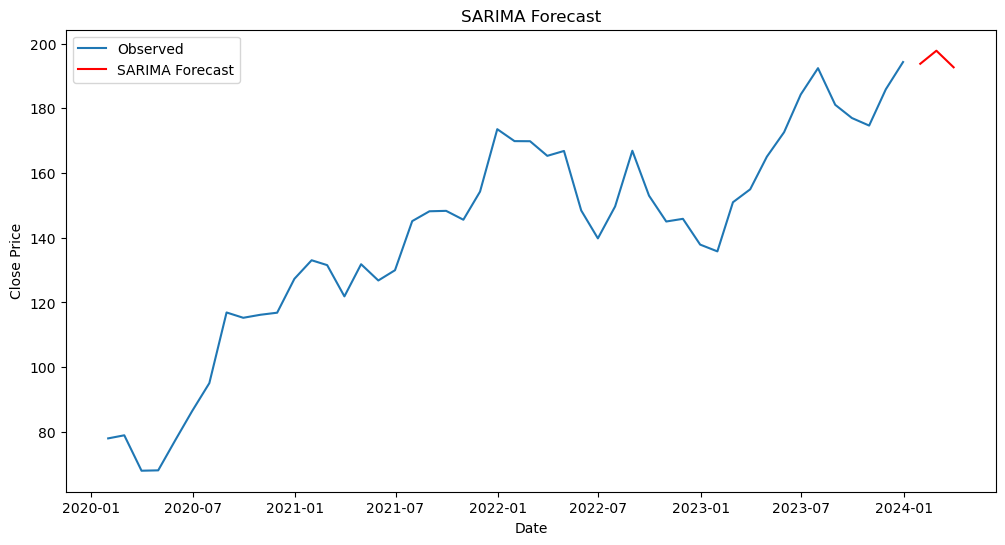

In [31]:
# Forecast for the next three months
forecast_sarima = fit_sarima.forecast(steps=3)
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Observed')
plt.plot(pd.date_range(start=monthly_data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M'), forecast_sarima, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [32]:
# Predict on the training data
forecast_sarima_train = fit_sarima.predict(start=0, end=len(monthly_data)-1)

In [35]:
# Compute metrics for SARIMA
rmse_sarima = np.sqrt(mean_squared_error(monthly_data, forecast_sarima_train))
mae_sarima = mean_absolute_error(monthly_data, forecast_sarima_train)
mape_sarima = np.mean(np.abs((monthly_data - forecast_sarima_train) / monthly_data)) * 100
r2_sarima = r2_score(monthly_data, forecast_sarima_train)

print(f'SARIMA Model - RMSE: {rmse_sarima}')
print(f'SARIMA Model - MAE: {mae_sarima}')
print(f'SARIMA Model - MAPE: {mape_sarima}')
print(f'SARIMA Model - R-squared: {r2_sarima}')

SARIMA Model - RMSE: 15.497382062019403
SARIMA Model - MAE: 9.541531908260552
SARIMA Model - MAPE: 7.975098129404243
SARIMA Model - R-squared: 0.7772673051803393


# Multivariate Forecasting

## LSTM Model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_data.values.reshape(-1, 1))

In [37]:
# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 12
X, Y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [38]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [39]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\Aakash\mlproject\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
# Train the model
model_lstm.fit(X_train, Y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
28/28 - 6s - 200ms/step - loss: 0.1070
Epoch 2/20
28/28 - 0s - 6ms/step - loss: 0.0154
Epoch 3/20
28/28 - 0s - 5ms/step - loss: 0.0111
Epoch 4/20
28/28 - 0s - 4ms/step - loss: 0.0158
Epoch 5/20
28/28 - 0s - 7ms/step - loss: 0.0122
Epoch 6/20
28/28 - 0s - 8ms/step - loss: 0.0101
Epoch 7/20
28/28 - 0s - 7ms/step - loss: 0.0100
Epoch 8/20
28/28 - 0s - 6ms/step - loss: 0.0104
Epoch 9/20
28/28 - 0s - 8ms/step - loss: 0.0110
Epoch 10/20
28/28 - 0s - 16ms/step - loss: 0.0094
Epoch 11/20
28/28 - 0s - 10ms/step - loss: 0.0095
Epoch 12/20
28/28 - 0s - 8ms/step - loss: 0.0109
Epoch 13/20
28/28 - 0s - 6ms/step - loss: 0.0115
Epoch 14/20
28/28 - 0s - 11ms/step - loss: 0.0131
Epoch 15/20
28/28 - 0s - 5ms/step - loss: 0.0119
Epoch 16/20
28/28 - 0s - 6ms/step - loss: 0.0115
Epoch 17/20
28/28 - 0s - 9ms/step - loss: 0.0104
Epoch 18/20
28/28 - 0s - 8ms/step - loss: 0.0089
Epoch 19/20
28/28 - 0s - 9ms/step - loss: 0.0092
Epoch 20/20
28/28 - 0s - 6ms/step - loss: 0.0107


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


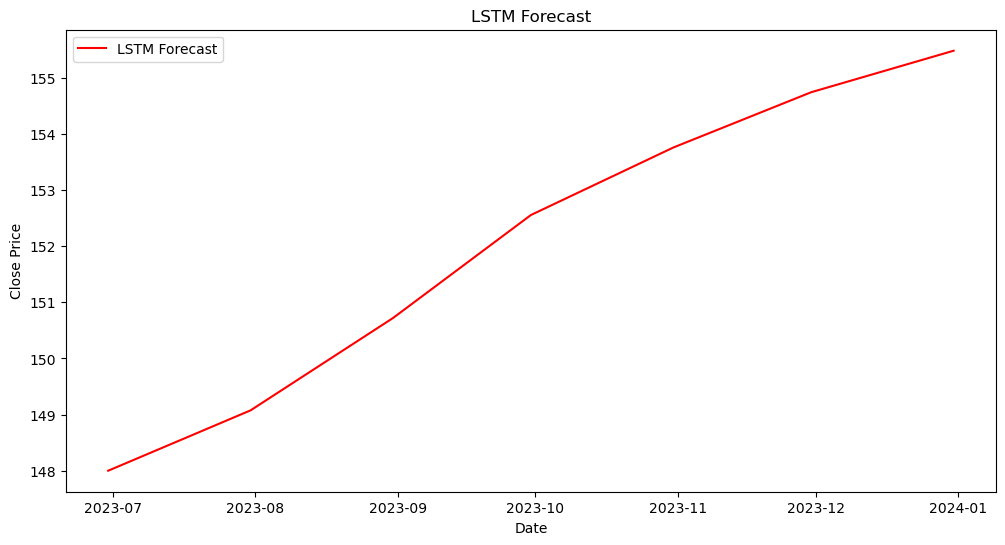

In [41]:
# Forecasting
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index[-len(Y_test):], predictions, label='LSTM Forecast', color='red')
plt.title('LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Tree-based Models (Random Forest, Decision Tree)

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Prepare data for tree-based models
X = np.arange(len(monthly_data)).reshape(-1, 1)
y = monthly_data.values

In [45]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [46]:
# Random Forest
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)
rf_predictions = model_rf.predict(X_test)

In [47]:
# Decision Tree
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)
dt_predictions = model_dt.predict(X_test)

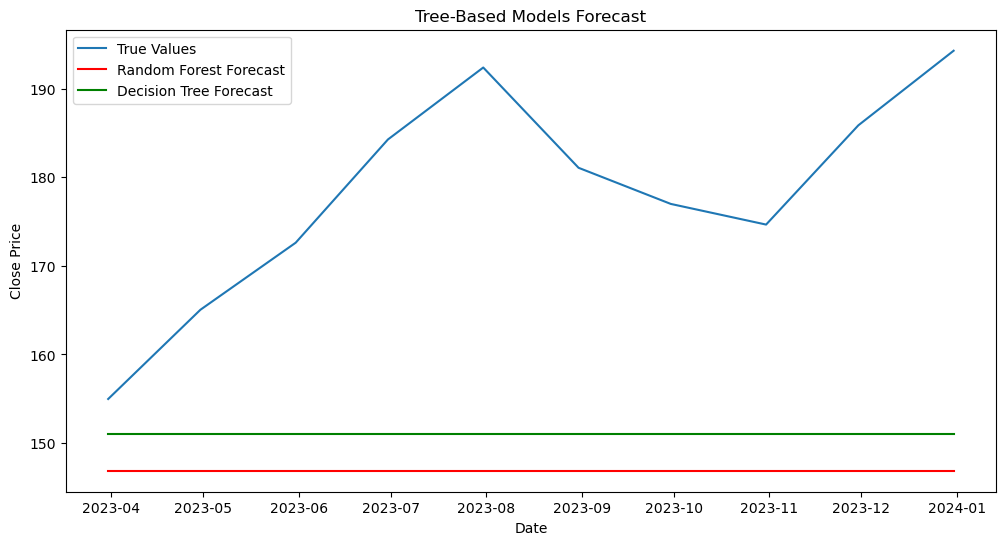

In [48]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index[-len(y_test):], y_test, label='True Values')
plt.plot(monthly_data.index[-len(y_test):], rf_predictions, label='Random Forest Forecast', color='red')
plt.plot(monthly_data.index[-len(y_test):], dt_predictions, label='Decision Tree Forecast', color='green')
plt.title('Tree-Based Models Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [49]:
# Random Forest predictions
rf_predictions = model_rf.predict(X_test)

# Decision Tree predictions
dt_predictions = model_dt.predict(X_test)

In [50]:
# Compute metrics for Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_predictions))
mae_rf = mean_absolute_error(y_test, rf_predictions)
mape_rf = np.mean(np.abs((y_test - rf_predictions) / y_test)) * 100
r2_rf = r2_score(y_test, rf_predictions)

print(f'Random Forest Model - RMSE: {rmse_rf}')
print(f'Random Forest Model - MAE: {mae_rf}')
print(f'Random Forest Model - MAPE: {mape_rf}')
print(f'Random Forest Model - R-squared: {r2_rf}')

Random Forest Model - RMSE: 33.40781035290112
Random Forest Model - MAE: 31.364241837995245
Random Forest Model - MAPE: 17.239897171254164
Random Forest Model - R-squared: -7.431777993811689


In [51]:
# Compute metrics for Decision Tree
rmse_dt = np.sqrt(mean_squared_error(y_test, dt_predictions))
mae_dt = mean_absolute_error(y_test, dt_predictions)
mape_dt = np.mean(np.abs((y_test - dt_predictions) / y_test)) * 100
r2_dt = r2_score(y_test, dt_predictions)

print(f'Decision Tree Model - RMSE: {rmse_dt}')
print(f'Decision Tree Model - MAE: {mae_dt}')
print(f'Decision Tree Model - MAPE: {mape_dt}')
print(f'Decision Tree Model - R-squared: {r2_dt}')

Decision Tree Model - RMSE: 29.58720787692382
Decision Tree Model - MAE: 27.258700325751896
Decision Tree Model - MAPE: 14.926344287588252
Decision Tree Model - R-squared: -5.613496164605442
